In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile # Para archivos wav

In [26]:
# Configuraciones

#Frecuencias Estándar de DTMF
frecuenciasBajas = [697, 770, 852, 941] # Filas
frecuenciasAltas = [1209, 1336, 1477, 1633] # Columnas

# Mapeo de dígitos a frecuencias DTMF
dtmfMap = {
    (697, 1209): '1', (697, 1336): '2', (697, 1477): '3', (697, 1633): 'A',
    (770, 1209): '4', (770, 1336): '5', (770, 1477): '6', (770, 1633): 'B',
    (852, 1209): '7', (852, 1336): '8', (852, 1477): '9', (852, 1633): 'C',
    (941, 1209): '*', (941, 1336): '0', (941, 1477): '#', (941, 1633): 'D'
}

In [27]:
# Algoritmo de Goertzel
def goertzel(samples, sample_rate, target_freq):
    N = len(samples)
    k = int(0.5 + (N * target_freq) / sample_rate)
    omega = (2.0 * np.pi * k) / N
    coeff = 2.0 * np.cos(omega)

    q1, q2 = 0.0, 0.0

    for sample in samples:
        q0 = coeff * q1 - q2 + sample
        q2 = q1
        q1 = q0
    
    magnitude = q1**2 + q2**2 - coeff * q1 * q2 # No tomo raiz cuadrada porque es costoso, solo quiero comparar más adelante asi que está bien
    return magnitude

In [ ]:
def decodificar_dtmf(audio_data, sample_rate, ventana_ms=40, umbral=500):
    """
    Recorre el array del audio y extrae la secuencia de digitos de DTMF
    
    Parámetros:
    audio_data: array numpy con los datos del audio
    sample_rate: frecuencia de muestreo del audio
    ventana_ms: tamaño de la ventana en milisegundos para analizar
    umbral: valor mínimo de magnitud para considerar una frecuencia detectada

    """

    step_size = int(sample_rate * ventana_ms / 1000)
    digitos = []
    ultimo_digito = None # Para evitar repeticiones consecutivas, si se apreta mucho tiempo una tecla
    # Cuando entra a la parte del silencio mas adelante se reinicia, entonces detecta bien numeros consecutivos

    for i in range(0, len(audio_data) - step_size, step_size):
        chunk = audio_data[i:i + step_size]

        # Itero por las frecuencias tabuladas, calculo la energia con Goertzel y veo cual es la mejor aproximada. 
        mejor_baja = None
        max_energia_baja = 0
        for freq in frecuenciasBajas:
            energia = goertzel(chunk, sample_rate, freq)
            if energia > umbral and energia > max_energia_baja:
                max_energia_baja = energia
                mejor_baja = freq
        
        # Busco la mejor frecuencia alta
        mejor_alta = None
        max_energia_alta = 0
        for freq in frecuenciasAltas:
            energia = goertzel(chunk, sample_rate, freq)
            if energia > umbral and energia > max_energia_alta:
                max_energia_alta = energia
                mejor_alta = freq
        
        # Si las encontré deben superar el umbral de ruido para ser considerados, evito falsos positivos, como ruido ambiental
        # Tambien considera que suenen ambas frecuencias, por ejemplo al hablar podria generar una frecuencia de 1209 Hz pero 
        # nada en las bajas, Goertzel devolveria un valor bajo en las altas, y en la baja podria detectar cualquier frecuencia
        # por lo que podria devolver un falso positivo.

        if max_energia_baja > umbral and max_energia_alta > umbral:
            caracter_actual = dtmfMap.get((mejor_baja, mejor_alta))
            if caracter_actual and caracter_actual != ultimo_digito:
                tiempo_actual = i / sample_rate # Convertir índice a segundos
                digitos.append((caracter_actual, tiempo_actual))
                ultimo_digito = caracter_actual
        else:
            ultimo_digito = None
    
    return digitos

In [45]:
def visualizar_resultados(audio, tasa, detecciones):
    """
    Gráfico profesional con 3 paneles:
    1. Forma de onda (Tiempo)
    2. Espectrograma (Frecuencia vs Tiempo)
    3. Matriz DTMF de referencia (Frecuencia Alta vs Baja)
    """
    
    # Datos de referencia para la matriz
    teclado = [
        ['1', '2', '3', 'A'],
        ['4', '5', '6', 'B'],
        ['7', '8', '9', 'C'],
        ['*', '0', '#', 'D']
    ]

    duracion = len(audio) / tasa
    tiempo = np.linspace(0, duracion, len(audio))

    # --- CONFIGURACIÓN DEL LAYOUT (GRILLA) ---
    fig = plt.figure(figsize=(15, 9))
    # Creamos una grilla de 2 filas x 4 columnas
    gs = gridspec.GridSpec(2, 4, figure=fig)

    # Subplot 1: Onda (Ocupa toda la fila de arriba)
    ax1 = fig.add_subplot(gs[0, :])
    
    # Subplot 2: Espectrograma (Ocupa fila de abajo, columnas 0, 1 y 2)
    ax2 = fig.add_subplot(gs[1, 0:3], sharex=ax1)
    
    # Subplot 3: Matriz DTMF (Ocupa fila de abajo, columna 3 - El panel lateral)
    ax3 = fig.add_subplot(gs[1, 3])

    # --- GRÁFICO 1: FORMA DE ONDA ---
    ax1.plot(tiempo, audio, color='royalblue', alpha=0.7)
    ax1.set_title('1. Señal de Audio en el Tiempo', fontsize=12, fontweight='bold', color='#333333')
    ax1.set_ylabel('Amplitud')
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Etiquetas de detección
    secuencia_texto = ""
    for digito, t_inicio in detecciones:
        secuencia_texto += digito
        ax1.axvline(x=t_inicio, color='red', linestyle='--', alpha=0.5)
        ax1.text(t_inicio, np.max(audio)*0.85, digito, color='white', fontsize=12, fontweight='bold', 
                 bbox=dict(boxstyle="round,pad=0.3", fc="red", ec="none", alpha=0.8))

    # --- GRÁFICO 2: ESPECTROGRAMA ---
    ax2.specgram(audio, NFFT=1024, Fs=tasa, noverlap=512, cmap='inferno')
    ax2.set_title('2. Espectrograma de Frecuencias', fontsize=12, fontweight='bold', color='#333333')
    ax2.set_ylabel('Frecuencia (Hz)')
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylim(0, 2000)

    # Líneas guía coloreadas (Clave para la presentación)
    # Cian para bajas, Amarillo para altas
    for f in frecuenciasBajas:
        ax2.axhline(y=f, color='cyan', linestyle=':', alpha=0.7, linewidth=1)
    for f in frecuenciasAltas:
        ax2.axhline(y=f, color='gold', linestyle=':', alpha=0.7, linewidth=1)

    # --- GRÁFICO 3: MATRIZ DTMF (LA NUEVA PARTE) ---
    ax3.set_title('3. Mapa de Tonos', fontsize=12, fontweight='bold', color='#333333')
    ax3.set_xlim(1100, 1750) # Rango eje X (Altas)
    ax3.set_ylim(600, 1050)  # Rango eje Y (Bajas)
    ax3.set_xlabel('Frecuencias Altas (Hz)')
    ax3.set_ylabel('Frecuencias Bajas (Hz)')
    ax3.set_facecolor('#f0f0f0') # Fondo gris suave para diferenciar

    # Dibujar la cuadrícula de la matriz
    for i, f_baja in enumerate(frecuenciasBajas):
        for j, f_alta in enumerate(frecuenciasAltas):
            tecla = teclado[i][j]
            
            # Dibujamos el caracter en la intersección
            ax3.text(f_alta, f_baja, tecla, ha='center', va='center', 
                     fontsize=18, fontweight='bold', color='#333333',
                     bbox=dict(boxstyle="circle,pad=0.4", fc="white", ec="gray", alpha=0.9))

    # Dibujar las líneas de la grilla matris (MISMOS COLORES QUE ESPECTROGRAMA)
    for f in frecuenciasBajas:
        ax3.axhline(y=f, color='cyan', linestyle='--', alpha=1, linewidth=2)
        # Etiqueta en el eje Y
        ax3.text(1120, f + 10, f"{f}Hz", color='teal', fontsize=8, fontweight='bold')

    for f in frecuenciasAltas:
        ax3.axvline(x=f, color='gold', linestyle='--', alpha=1, linewidth=2)
        # Etiqueta en el eje X (rotada para que quepa)
        ax3.text(f, 620, f"{f}Hz", color='goldenrod', fontsize=8, fontweight='bold', rotation=90)

    plt.tight_layout()
    plt.show()
    
    return secuencia_texto

c:\Users\tadem\AppData\Local\Programs\Python\Python313\Lib\site-packages\matplotlib\axes\_axes.py:8280: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


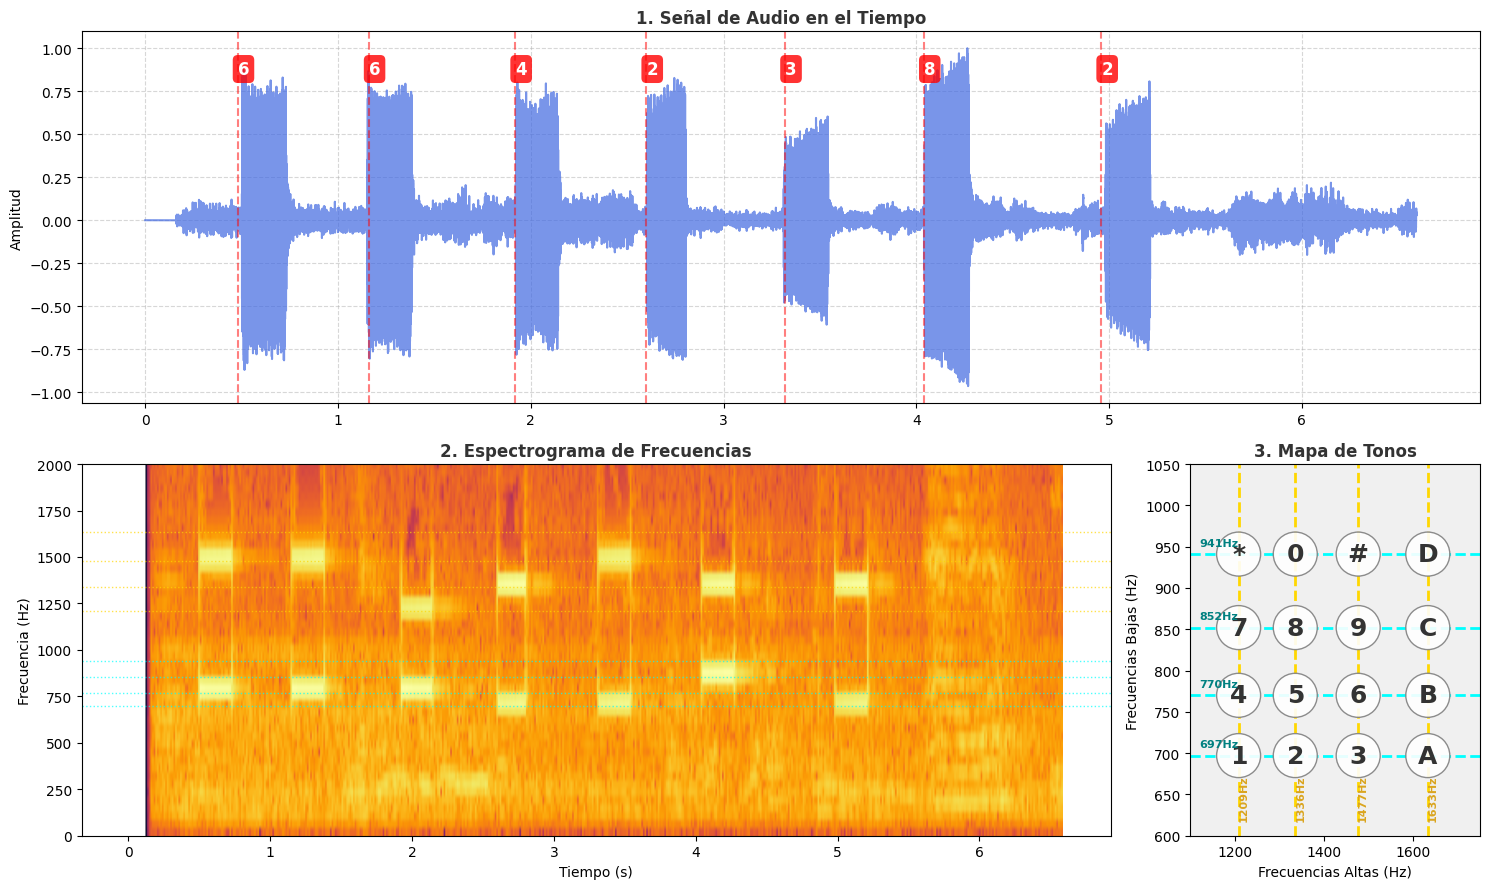

Secuencia de digitos: 6642382


In [46]:
tasa, datos = wavfile.read("audios/cel_Mauri.wav")
if len(datos.shape) > 1:
    datos = datos[:, 0]  # Usar solo un canal si es estéreo

# Normalizar los datos para que el umbral funcione constante
datos = datos / np.max(np.abs(datos) + 1e-10)  # Evitar división por cero

detecciones = decodificar_dtmf(datos, tasa, ventana_ms=40, umbral=5000)

secuencia_final = visualizar_resultados(datos, tasa, detecciones)

print(f"Secuencia de digitos: {secuencia_final}")